# Moral dilemmas, machine learning and misconceptions

The trolley problem is a classical ethical dilemma with no simple answer. It has been features in multiple pop culture productions such as the movie The Dark Knight or the TV series The Good Place.

Here is how the story goes. Suppose you are standing next to a lever that can shift the path taken by a trolley. Initially the trolley is on a track that will lead it in the direction of five people who cannot escape the incoming thread. If you do nothing these five people will die. However, if you pull the trigger the trolley is lead to a different path and will hit and kill only one person. This begs several questions:

- Should you pull the trigger?
- Is it ethical to choose to kill one person in order to save five?
- Or the opposite, to spare the life of one person at the cost of another five.

<p align="center">
  <img src="../images/0b0584bf02449513f879837cc95f19e7e0-09-trolley.rhorizontal.w700.webp" alt="The trolley problem"/>
  <br>
  <em>The trolley problem in its classical variation. Image obtained from: https://nymag.com/intelligencer/2016/08/trolley-problem-meme-tumblr-philosophy.html</em>
</p>

Awald et al (2020) have designed an online survey where participants are asked to answer to different situations. Interestingly, alternative versions of the same problem are presented. This will be further explained ahead.


The original paper can be found here:

https://www.pnas.org/doi/10.1073/pnas.1911517117

The authors have made the data available on:

https://osf.io/mxa6z/?view_only=33719a32d86a4ec186a21287a233040c

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno
from scipy.stats import mannwhitneyu, ttest_ind
from statsmodels.stats.proportion import proportion_confint

In [2]:
plt.style.use("ggplot")

## 1 - Data acquisition

In [3]:
df_official_language_raw = pd.read_csv("../data/official-language.csv")
df_shared_data_demographics_raw = pd.read_csv("../data/Shared_data_responses_demographics.csv")

In [4]:
df_official_language_raw.head(2)

,country,language
0,ABW,pt
1,AFG,fa


In [5]:
df_shared_data_demographics_raw.head(2)

,UserIP_Anonymized,Scenario,survey.age,survey.gender,survey.education,survey.political,survey.religious,country_code,Outcome,Continent
0,0002ae2d,Footbridge,19,Women,College,0.56,0.0,GB,0,Europe
1,0002ae2d,Loop,19,Women,College,0.56,0.0,GB,1,Europe


The dataframe we will use for the analysis is df_shared_data_demographics, it shows the results for the survey. Each line corresponds to a participant response, three possible situations were presented ("Scenario" column) for each possible intervention a person could do:

<p align="center">
  <img src="../images/switch-loop-footbridge-2.jpg" alt="Possible scenarios"/>
  <br>
  <em> The three scenarios for the trolley problem. Obatined from Awald et al. (2020) </em>
</p>

From the image above we can discuss the three situations presented in the survey:

*Switch*: in this first version, the intervention of the participant shifts the path of the trolley leading it to kill only one person instead of five

*Loop*: now, the situation becomes a little more complicated, in order to save the five workers, the trolley must be lead to a path with only one person. The impact will lead the trolley to stop.

*Footbridge*: now, once again the option involves the impact of the trolley with a person who is standing on the bride. He is a big person, and the shock will be enough to stop the menace from killing the five people. But now there is no lever available, it is necessary to personally push the person, which involves physical contact.

Additional information are presented to each participant:
- age on "survey.age",
- gender on "survey.gender"
- education on "survey.education"
- political on "survey.political", ranging from 0 to 1, corresponding to conservative to progressive
- religious views on "survey.religious", ranging from 0 to 1, corresponding to non-religious to religious
- country code on "country_code"
- continent on "Continent"
- Outcome on "outcome": this column indicates the action chosen by the participant, 0 if the person would not intervene and 1 otherwise
- "UserIP_Anonymized" is an individual ID for each person

Based on this data we can study the characteristics of each group. Following, we can try and answer: based on a give set of attributes (age, gender...) will the person intervene or not.

In [108]:
df_shared_data_demographics_raw.describe()

,survey.age,survey.political,survey.religious,Outcome
count,59159.000000,59159.000000,59159.000000,59159.000000
mean,28.067834,0.628667,0.243850,0.688889
std,10.213054,0.263498,0.302178,0.462952
min,18.000000,0.000000,0.000000,0.000000
25%,21.000000,0.500000,0.000000,0.000000
50%,25.000000,0.620000,0.070000,1.000000
75%,32.000000,0.840000,0.500000,1.000000
max,89.000000,1.000000,1.000000,1.000000


## 2 - Data cleaning

### 2.1 - Missing data

<AxesSubplot:>

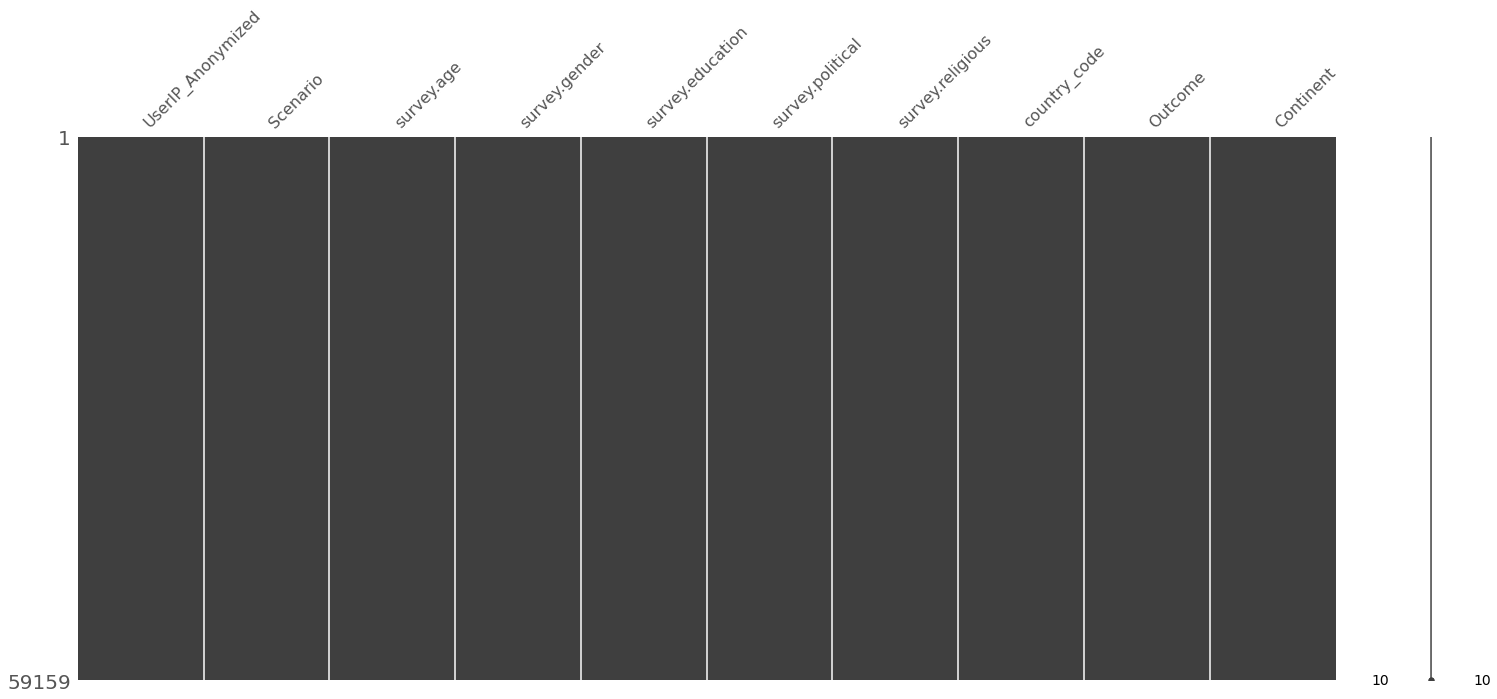

In [6]:
missingno.matrix(df_shared_data_demographics_raw, sort="ascending")

Both dataframes present no missing data, from the previous visualizations all columns are complete for both objects.

### 2.2 - Basic cleaning and column selection

In [7]:
df_shared_data_demographics_clean = (
    df_shared_data_demographics_raw
    .rename(columns={
        "UserIP_Anonymized":"id",
        "Scenario":"scenario",
        "survey.age":"age",
        "survey.gender":"gender",
        "survey.education":"education",
        "survey.political":"political",
        "survey.religious":"religious",
        "country_code":"country",
        "Outcome":"outcome",
        "Continent":"continent"
    })
)

## 3 - Data visualization

### 3.1 - Age pyramid

In [8]:
df_age_pyramid = (
    df_shared_data_demographics_clean
    .assign(
        age_range = lambda df: pd.cut(df["age"], bins=np.arange(0, 101, 5), right=False, labels=[f"{i}-{i+5}" for i in np.arange(0, 96, 5)])
    )
    .groupby(["age_range", "gender", "scenario", "outcome"])
    .agg(
        number_people=("id", "nunique")
    )
    .reset_index()
)

In [9]:
df_age_pyramid.head(2)

,age_range,gender,scenario,outcome,number_people
0,0-5,Men,Footbridge,0,0
1,0-5,Men,Footbridge,1,0


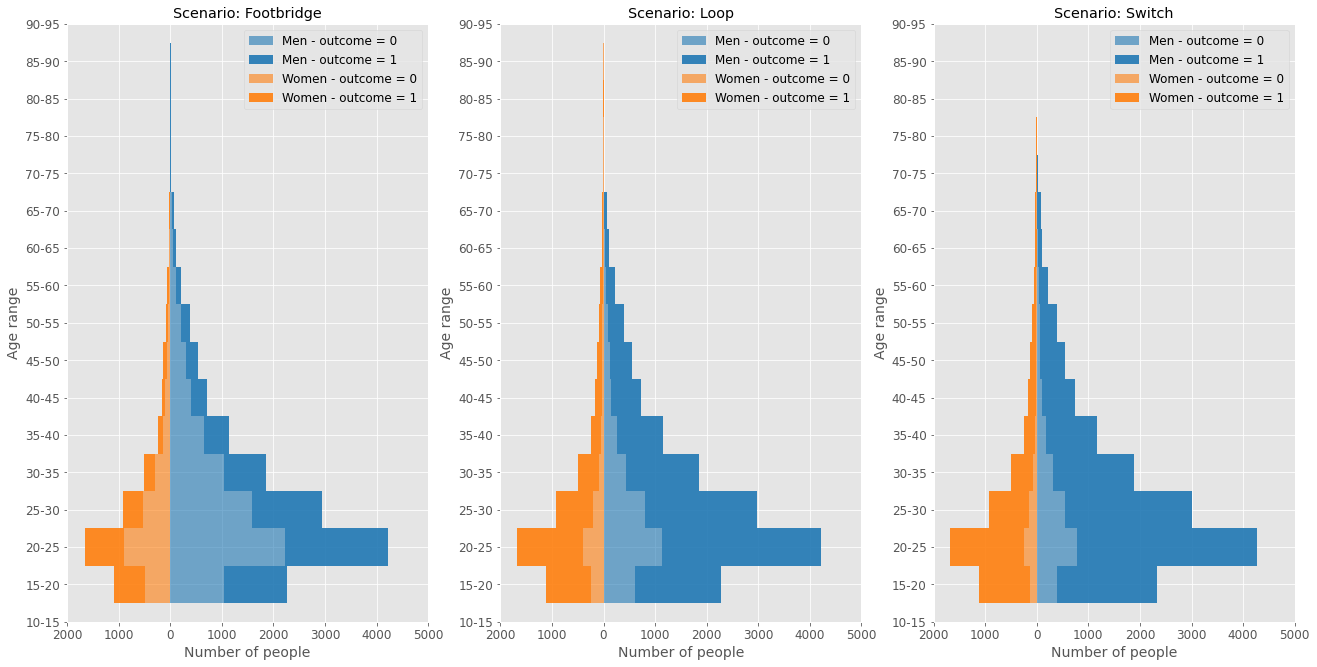

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(22,11))
y_aux = np.arange(0, df_age_pyramid["age_range"].nunique())

for i, scenario in enumerate(df_age_pyramid["scenario"].unique()):
    aux_data = df_age_pyramid.query(f"scenario == '{scenario}'").drop(columns="scenario")

    ax[i].barh(
        y=y_aux,
        width=aux_data.query("gender == 'Men' & outcome == 0")["number_people"],
        height=1,
        align="center",
        label="Men - outcome = 0",
        color=plt.cm.tab10.colors[0],
        alpha=0.6
    )

    ax[i].barh(
        y=y_aux,
        width=aux_data.query("gender == 'Men' & outcome == 1")["number_people"],
        left=aux_data.query("gender == 'Men' & outcome == 0")["number_people"],
        height=1,
        align="center",
        label="Men - outcome = 1",
        color=plt.cm.tab10.colors[0],
        alpha=0.9
    )

    ax[i].barh(
        y=y_aux,
        width=-aux_data.query("gender == 'Women' & outcome == 0")["number_people"],
        height=1,
        align="center",
        label="Women - outcome = 0",
        color=plt.cm.tab10.colors[1],
        alpha=0.6
    )

    ax[i].barh(
        y=y_aux,
        width=-aux_data.query("gender == 'Women' & outcome == 1")["number_people"],
        left=-aux_data.query("gender == 'Women' & outcome == 0")["number_people"],
        height=1,
        align="center",
        label="Women - outcome = 1",
        color=plt.cm.tab10.colors[1],
        alpha=0.9
    )

    ax[i].legend(fontsize=12)
    ax[i].set_xticks(np.arange(-2000, 5001, 1000))
    ax[i].set_xticklabels(np.abs(np.arange(-2000, 5001, 1000)), fontsize=12)
    ax[i].set_yticks(y_aux)
    ax[i].set_yticklabels(df_age_pyramid["age_range"].unique(), fontsize=12)
    ax[i].set_ylim(2, 18)
    ax[i].set_xlabel("Number of people", fontsize=14)
    ax[i].set_ylabel("Age range", fontsize=14)
    ax[i].set_title(f"Scenario: {scenario}")

Above it is possible to see the age pyramid clustered for the three scenarios. The lighter colors indicate the participant didn't take the action, while the darker one indicates he/she did take the action. It is noticeable that interventions are more common for the Switch, and very less frequent for the Footbridge given the same gender and age range.

The diversity of the participants is also unbalanced, there are more men than women in the survey. Additionally, the participants tend to be young adults.

Following, let's investigate if the responses are statistically associated with gender and age.

### 3.2 - Age and gender statistical tests

In [25]:
df_age_per_group = (
    df_shared_data_demographics_clean
    .groupby(["scenario", "outcome"])
    .agg(
        age_list=("age", list)
    )
    .reset_index()
)

In [26]:
df_age_per_group.head(2)

,scenario,outcome,age_list
0,Footbridge,0,"[19, 20, 35, 24, 34, 25, 19, 47, 24, 21, 33, 2..."
1,Footbridge,1,"[19, 21, 20, 28, 28, 31, 19, 19, 55, 21, 24, 2..."


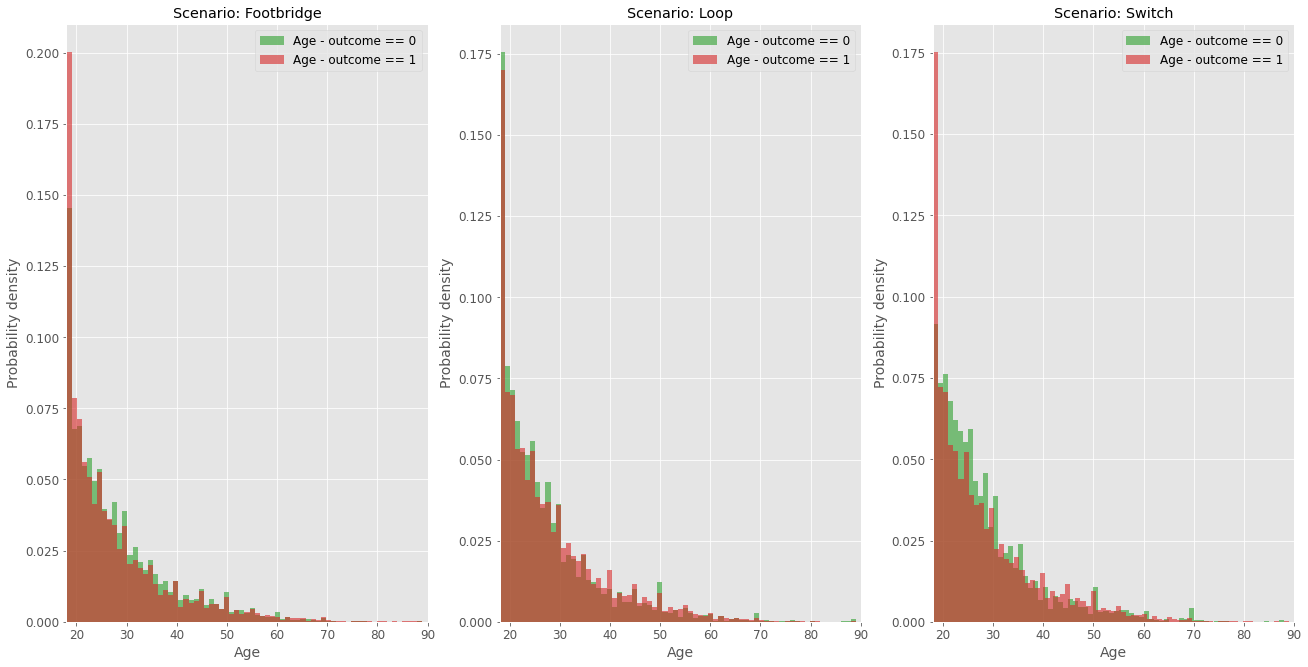

In [105]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(22,11))

BINS = 70

for i, scenario in enumerate(df_age_per_group["scenario"].unique()):
    y_0, x_0, _ = ax[i].hist(
        df_age_per_group.query(f"scenario == '{scenario}' & outcome == 0")["age_list"],
        bins=BINS,
        color=plt.cm.tab10.colors[2],
        alpha=0.6,
        density=True,
        label="Age - outcome == 0"
    )

    y_1, x_1, _ = ax[i].hist(
        df_age_per_group.query(f"scenario == '{scenario}' & outcome == 1")["age_list"],
        bins=BINS,
        color=plt.cm.tab10.colors[3],
        alpha=0.6,
        density=True,
        label="Age - outcome == 1"
    )

    ax[i].set_xlabel("Age", fontsize=14)
    ax[i].set_ylabel("Probability density", fontsize=14)
    ax[i].set_title(f"Scenario: {scenario}")
    ax[i].tick_params(axis='both', which='major', labelsize=12)
    ax[i].set_xlim(18, 90)
    ax[i].legend(fontsize=12);

From the age distribution shown above, the population is very centered around 20 year, and the data does not seem to follow a normal-like distribution as it typically happens with population analysis. In this case, the data seems to have an exponential-like behavior.

In [92]:
df_gender_scenario = (
    df_shared_data_demographics_clean
    .groupby(["scenario", "gender", "outcome"])
    .agg(
        number_people=("id", "nunique")
    )
    .reset_index()
    .assign(
        total_scenario = lambda df: df.groupby(["scenario", "outcome"])["number_people"].transform(lambda x: x.sum()),
        lower_bound = lambda df: 100*proportion_confint(df["number_people"], df["total_scenario"])[0],
        upper_bound = lambda df: 100*proportion_confint(df["number_people"], df["total_scenario"])[1],
        relative_frequency = lambda df: 100*df["number_people"]/df["total_scenario"],
        interval = lambda df: df["upper_bound"] - df["lower_bound"]
    )
)

In [93]:
df_gender_scenario.head(2)

,scenario,gender,outcome,number_people,total_scenario,lower_bound,upper_bound,relative_frequency,interval
0,Footbridge,Men,0,7663,10299,73.562476,75.248088,74.405282,1.685612
1,Footbridge,Men,1,6759,9036,73.905625,75.695969,74.800797,1.790344


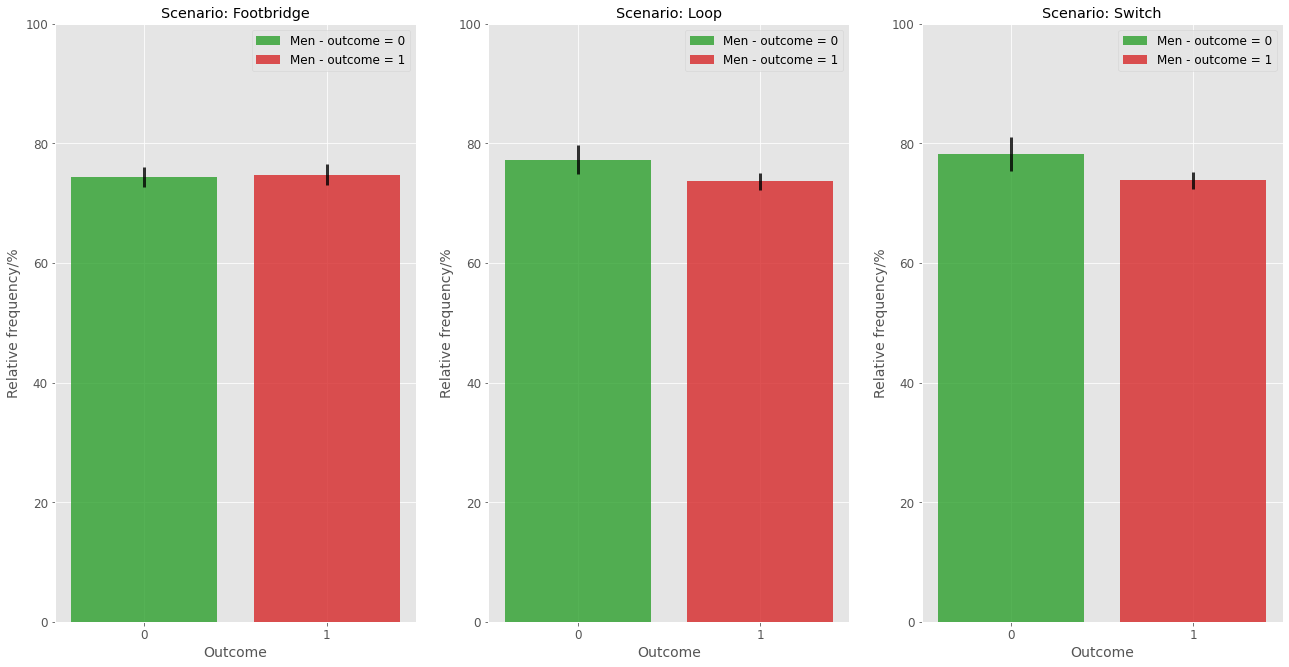

In [107]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(22,11))

for i, scenario in enumerate(df_gender_scenario["scenario"].unique()):
    ax[i].bar(
        [0],
        df_gender_scenario.query(f"gender == 'Men' & outcome == 0 & scenario == '{scenario}'")["relative_frequency"],
        color=plt.cm.tab10.colors[2],
        alpha=0.8,
        label="Men - outcome = 0"
    )

    ax[i].errorbar(
        [0],
        y=df_gender_scenario.query(f"gender == 'Men' & outcome == 0 & scenario == '{scenario}'")["relative_frequency"],
        yerr=df_gender_scenario.query(f"gender == 'Men' & outcome == 0 & scenario == '{scenario}'")["interval"],
        elinewidth=3,
        ecolor="k",
        alpha=0.8
    )

    ax[i].bar(
        [1],
        df_gender_scenario.query(f"gender == 'Men' & outcome == 1 & scenario == '{scenario}'")["relative_frequency"],
        color=plt.cm.tab10.colors[3],
        alpha=0.8,
        label="Men - outcome = 1"
    )

    ax[i].errorbar(
        [1],
        y=df_gender_scenario.query(f"gender == 'Men' & outcome == 1 & scenario == '{scenario}'")["relative_frequency"],
        yerr=df_gender_scenario.query(f"gender == 'Men' & outcome == 1 & scenario == '{scenario}'")["interval"],
        elinewidth=3,
        ecolor="k",
        alpha=0.8
    )

    ax[i].set_ylim(0, 100)
    ax[i].set_xticks(np.arange(0, 2))
    ax[i].set_xlabel("Outcome", fontsize=14)
    ax[i].set_ylabel("Relative frequency/%", fontsize=14)
    ax[i].set_title(f"Scenario: {scenario}")
    ax[i].tick_params(axis='both', which='major', labelsize=12)
    ax[i].legend(fontsize=12);

The graph above displays the relative frequency for Men grouped by each outcome in each scenario. One can notice that for the Footbridge case, there seems to be no significant difference between the frequencies of men at each outcome. However, for the other two scenarios, men seem to be less prone to take an action.

### 3.3 - Political views

In [109]:
df_shared_data_demographics_clean.head(2)

,id,scenario,age,gender,education,political,religious,country,outcome,continent
0,0002ae2d,Footbridge,19,Women,College,0.56,0.0,GB,0,Europe
1,0002ae2d,Loop,19,Women,College,0.56,0.0,GB,1,Europe


In [112]:
df_politics_scenario = (
    df_shared_data_demographics_clean
    .groupby(["scenario", "outcome"])
    .agg(
        political=("political", list)
    )
    .reset_index()
)

In [113]:
df_politics_scenario.head()

,scenario,outcome,political
0,Footbridge,0,"[0.56, 0.58, 0.94, 0.5, 0.5, 0.87, 0.38, 1.0, ..."
1,Footbridge,1,"[0.0, 0.39, 0.5, 1.0, 0.83, 0.12, 0.74, 0.5, 0..."
2,Loop,0,"[0.0, 0.58, 0.87, 0.38, 1.0, 0.79, 0.82, 0.83,..."
3,Loop,1,"[0.56, 0.5, 0.39, 0.5, 1.0, 0.94, 0.83, 0.5, 0..."
4,Switch,0,"[0.58, 0.87, 0.5, 1.0, 0.82, 0.93, 0.5, 0.83, ..."


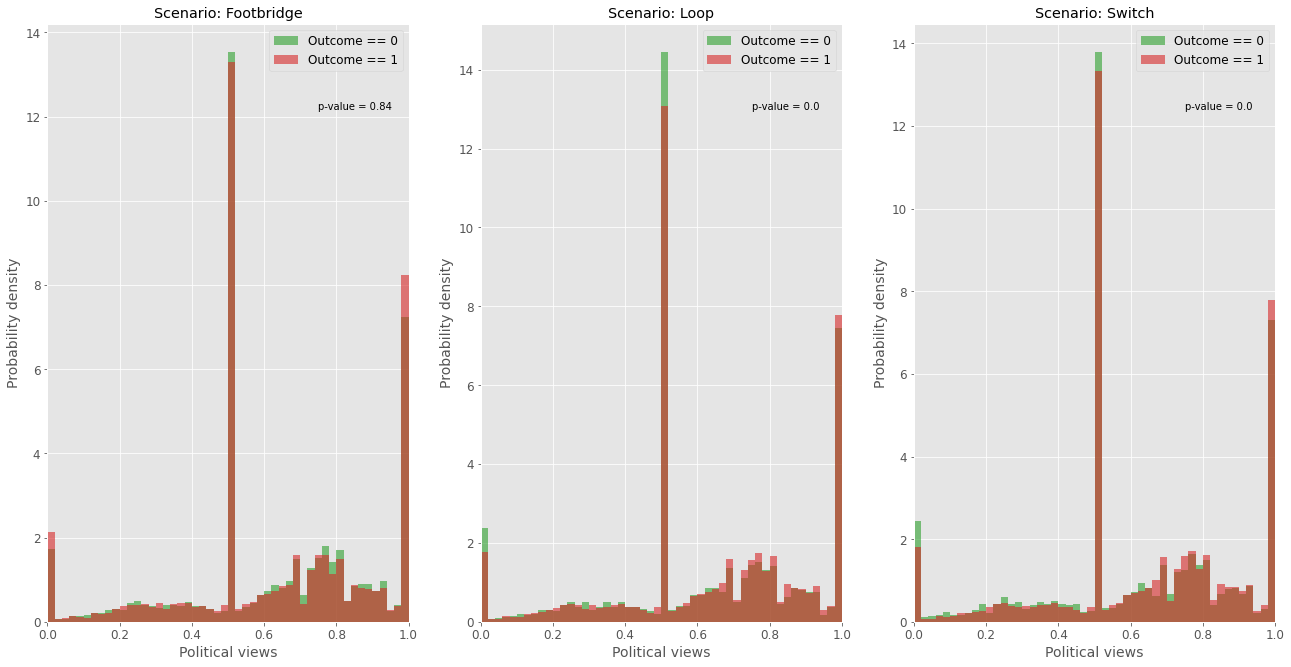

In [124]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(22,11))
BINS = 50
for i, scenario in enumerate(df_politics_scenario["scenario"].unique()):
    y0, x0, _ = ax[i].hist(
        df_politics_scenario.query(f"scenario == '{scenario}' & outcome == 0")["political"],
        bins=BINS,
        density=True,
        color=plt.cm.tab10.colors[2],
        alpha=0.6,
        label="Outcome == 0"
    )

    y1, x1, _ = ax[i].hist(
        df_politics_scenario.query(f"scenario == '{scenario}' & outcome == 1")["political"],
        bins=BINS,
        density=True,
        color=plt.cm.tab10.colors[3],
        alpha=0.6,
        label="Outcome == 1"
    )

    _, p_value = ttest_ind(
        df_politics_scenario.query(f"scenario == '{scenario}' & outcome == 0")["political"].values[0],
        df_politics_scenario.query(f"scenario == '{scenario}' & outcome == 1")["political"].values[0],
    )

    ax[i].annotate(
        f"p-value = {np.round(p_value, 2)}",
        xy=(0.75*np.max([x0, x1]), 0.9*np.max([y0, y1]))
    )

    ax[i].set_xlabel("Political views", fontsize=14)
    ax[i].set_ylabel("Probability density", fontsize=14)
    ax[i].set_xlim(0, 1)
    ax[i].tick_params(axis='both', which='major', labelsize=12)
    ax[i].set_title(f"Scenario: {scenario}")
    ax[i].legend(fontsize=12)

In [123]:
(
    df_shared_data_demographics_clean
    .groupby(["scenario", "outcome"])
    .agg(
        political_views=("political", "mean")
    )
    .reset_index()
    .pivot(
        index="scenario",
        columns="outcome",
        values="political_views"
    )
)

outcome,0,1
scenario,,
Footbridge,0.629286,0.628529
Loop,0.611545,0.633625
Switch,0.608016,0.632802


The previous histogram shows the dispersion of the political views under each scenario and separated by outcomes. For the footbridge situation, the difference in means is not statistically significant. However, for other cases, the group of people how opt for a positive action (outcome = 1) seems to be more aligned with progressive views as the p-values indicated in the plot indicates alongside the previous table.

### 3.4 - Religious views

In [126]:
df_religious_scenario = (
    df_shared_data_demographics_clean
    .groupby(["scenario", "outcome"])
    .agg(
        religious=("religious", list)
    )
    .reset_index()
)

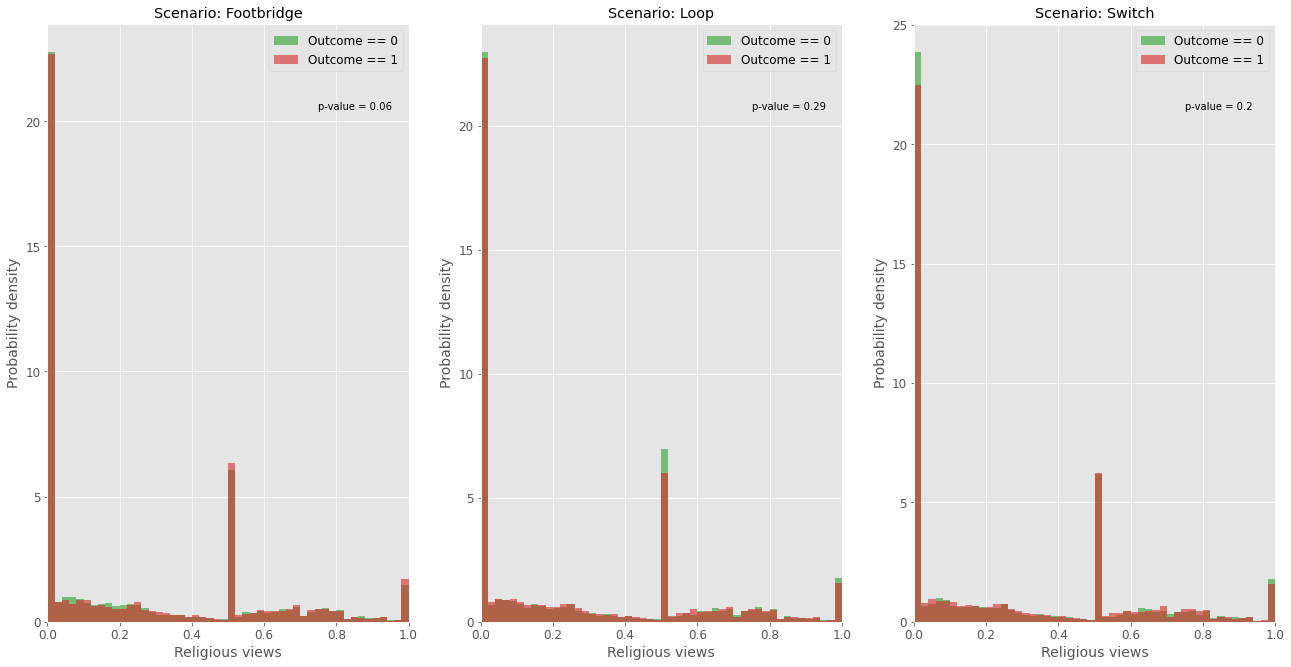

In [127]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(22,11))
BINS = 50
for i, scenario in enumerate(df_religious_scenario["scenario"].unique()):
    y0, x0, _ = ax[i].hist(
        df_religious_scenario.query(f"scenario == '{scenario}' & outcome == 0")["religious"],
        bins=BINS,
        density=True,
        color=plt.cm.tab10.colors[2],
        alpha=0.6,
        label="Outcome == 0"
    )

    y1, x1, _ = ax[i].hist(
        df_religious_scenario.query(f"scenario == '{scenario}' & outcome == 1")["religious"],
        bins=BINS,
        density=True,
        color=plt.cm.tab10.colors[3],
        alpha=0.6,
        label="Outcome == 1"
    )

    _, p_value = ttest_ind(
        df_religious_scenario.query(f"scenario == '{scenario}' & outcome == 0")["religious"].values[0],
        df_religious_scenario.query(f"scenario == '{scenario}' & outcome == 1")["religious"].values[0],
    )

    ax[i].annotate(
        f"p-value = {np.round(p_value, 2)}",
        xy=(0.75*np.max([x0, x1]), 0.9*np.max([y0, y1]))
    )

    ax[i].set_xlabel("Religious views", fontsize=14)
    ax[i].set_ylabel("Probability density", fontsize=14)
    ax[i].set_xlim(0, 1)
    ax[i].tick_params(axis='both', which='major', labelsize=12)
    ax[i].set_title(f"Scenario: {scenario}")
    ax[i].legend(fontsize=12)

In [128]:
(
    df_shared_data_demographics_clean
    .groupby(["scenario", "outcome"])
    .agg(
        religous_views=("religious", "mean")
    )
    .reset_index()
    .pivot(
        index="scenario",
        columns="outcome",
        values="religous_views"
    )
)

outcome,0,1
scenario,,
Footbridge,0.239746,0.248050
Loop,0.247548,0.242242
Switch,0.238063,0.245603


Interestingly, in the case of religion, there seems to be no statistically significant difference between the views of people who don't take the action (outcome == 0) and those who take (outcome == 1). The most critical case occurs for the footbridge scenario, as the p-value calculated through t-test is relatively small (0.06). In this case, the people who take the action are on average more religious than those who do not take it.

### 3.5 - Regional tendencies